In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [2]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [4]:
model_name = 'processed bonemarrow'
model_name = 'EG_ab_dyn'
#model_name = 'DentateGyrus'
result_path = 'results/'+model_name+'/'
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
data_name = 'EG_ab_dyn.h5ad'
#data_name = 'processed bonemarrow.h5ad'

In [5]:
adata0=scv.read(data_path+data_name, cache=True)

In [6]:
adata0

AnnData object with n_obs × n_vars = 2322 × 764
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'clusters_colors', 'clusters_fine_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'grid_velocity_umap', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'pca_mean', 'pp'
    obsm: 'X', '

In [8]:
cell_nei = np.load(result_path+'cell_nei'+'.npy')
nei_w = np.load(result_path+'nei_w'+'.npy')
X = np.load(result_path+'X'+'.npy')
X_pca = np.load(result_path+'X_pca'+'.npy')
encoder = torch.load(result_path+'encoder'+'.pt')
color_label = np.load(result_path+'color_label'+'.npy')

In [9]:
L = 6

In [10]:
##Fisher matrix
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
diag_elements = np.concatenate([1 / sigma_learned ** 2, 2 / sigma_learned ** 2], axis=-1)
Fisher_g = np.zeros((X.shape[0], 2 * L, 2 * L))
for i in range(X.shape[0]):
    np.fill_diagonal(Fisher_g[i], diag_elements[i])

In [5]:
#Fisher_g = np.load(result_path+'随机基因2055/'+'k_nei=10/K=3 L=6/'+'Fisher_g.npy')

In [11]:
def EigenIF(Fisher_g):
    n,L,_ = Fisher_g.shape
    L=int(L/2)
    Eigenvalue = np.zeros((n,L))
    for i in range(n):
        for j in range(L):
            Eigenvalue[i,j] = Fisher_g[i,j,j]
    sorted_Eigenvalue = np.sort(Eigenvalue, axis=1)
    sorted_Eigenvalue = sorted_Eigenvalue[:, ::-1]
    relative_Eigenvalue = sorted_Eigenvalue[:,1:]/sorted_Eigenvalue[:,0].reshape(n,1)
    return Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue

Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue = EigenIF(Fisher_g)

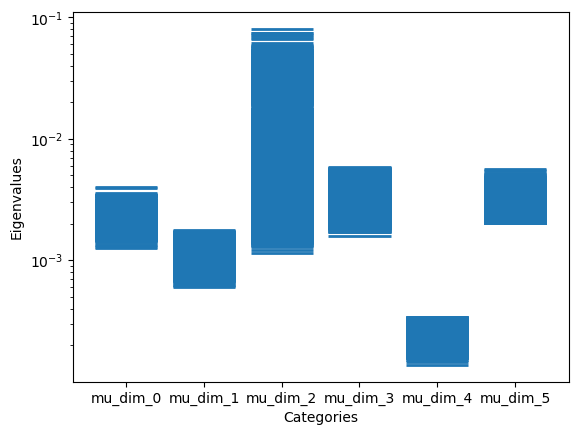

In [12]:
##各个维度特征值
categories = []
eigenvalues = {}
for i in range(L):
    categories.append(f'mu_dim_{i}')
    eigenvalues[f'mu_dim_{i}'] = Eigenvalue[:,i]

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2)

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)

ax.set_xlabel('Categories')
ax.set_ylabel('Eigenvalues')

plt.show()

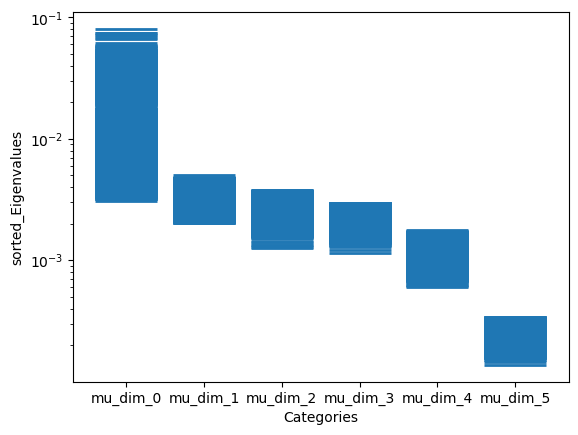

In [13]:
###每个细胞特征值排序
categories = []
eigenvalues = {}
for i in range(L):
    categories.append(f'mu_dim_{i}')
    eigenvalues[f'mu_dim_{i}'] = sorted_Eigenvalue[:,i]

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2)

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)

ax.set_xlabel('Categories')
ax.set_ylabel('sorted_Eigenvalues')

plt.show()

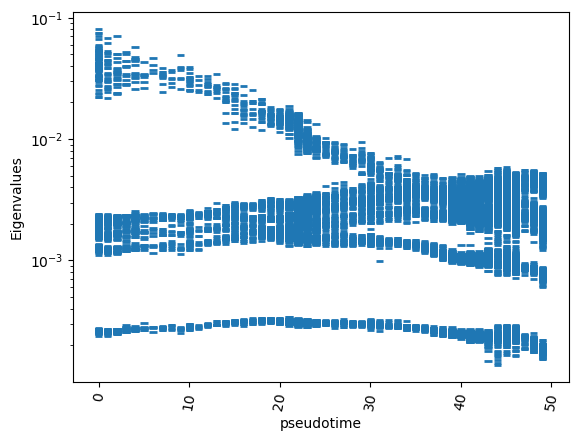

In [18]:
# pseudotime 均值
categories = []
eigenvalues = {}
N = 50
for i in range(N):
    categories.append(f'part{i+1}')
    #eigenvalues[f'part{i+1}'] = np.sum(Eigenvalue[(color_label>(i/N))&(color_label<(i+1)/N)], axis=0)
    eigenvalues[f'part{i+1}'] = Eigenvalue[(color_label>(i/N))&(color_label<(i+1)/N)]


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4, lw=2)

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])

#ax.set_xticks(range(len(categories)))
#ax.set_xticklabels(categories)
plt.xticks(rotation=80)

ax.set_xlabel('pseudotime')
ax.set_ylabel('Eigenvalues')

plt.show()

In [19]:
clusters = adata0.obs['clusters']

In [20]:
categories = list(set(clusters))
categories

['Ngn3 low EP', 'Beta', 'Alpha', 'Fev+', 'Ngn3 high EP']

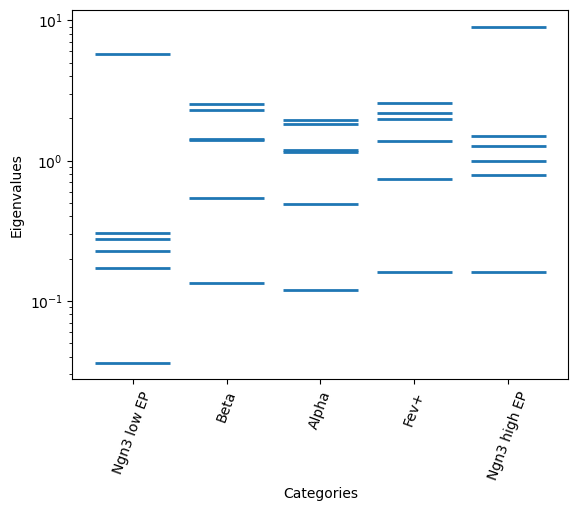

In [21]:
##cluster 均值
categories = list(set(clusters))
eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.sum(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2)

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
plt.xticks(rotation=70)

ax.set_xlabel('Categories')
ax.set_ylabel('Eigenvalues')

plt.show()

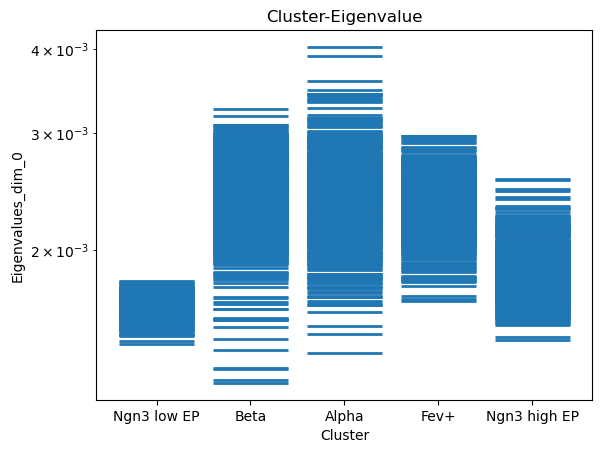

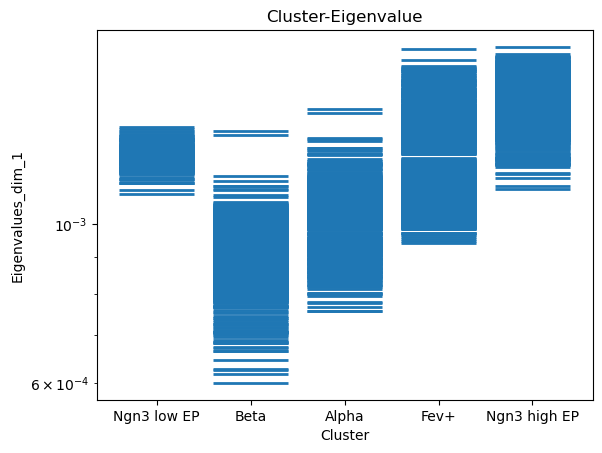

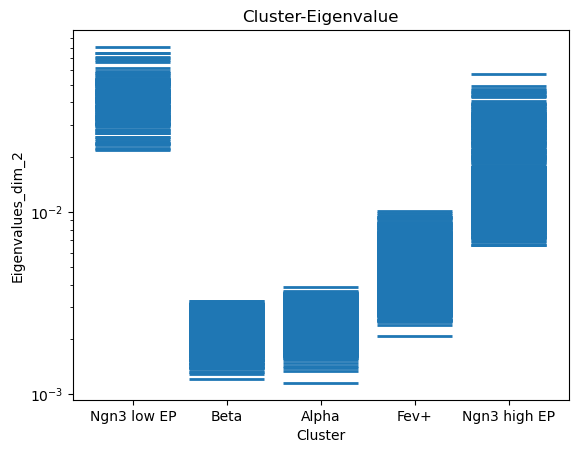

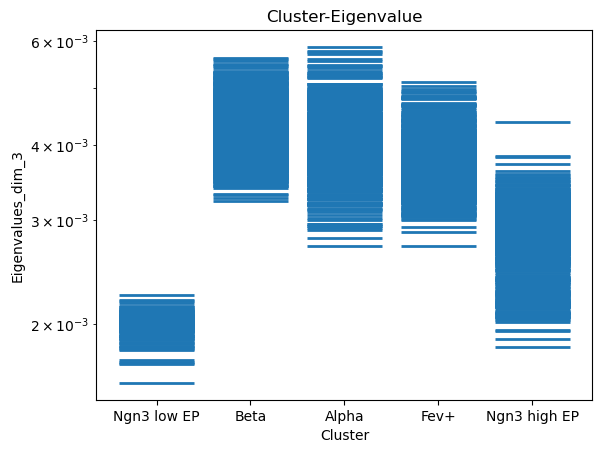

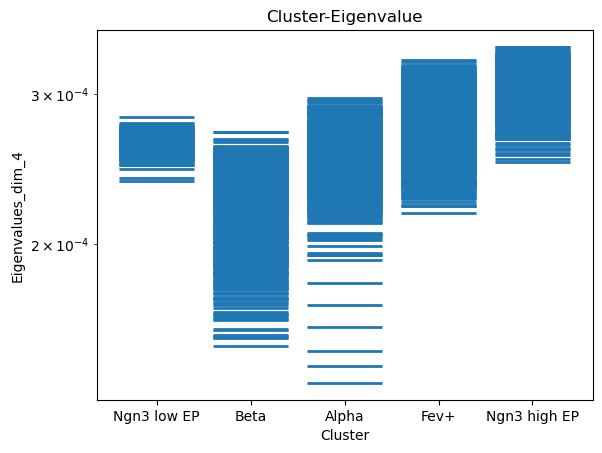

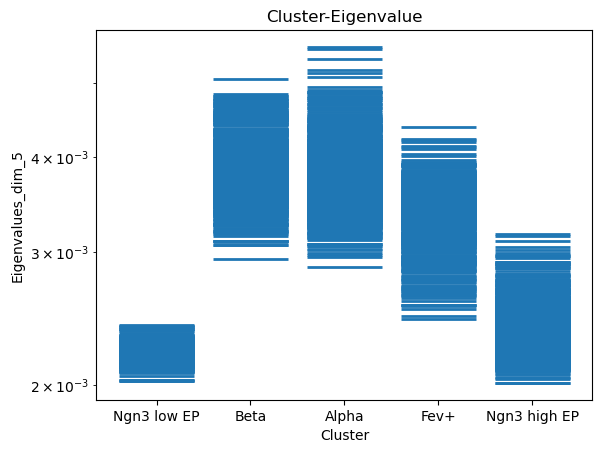

In [24]:
##cluster 各个维度  注意y轴范围
categories = list(set(clusters))
eigenvalues = {}
for k in range(L):
    for i in categories:
        eigenvalues[i] = Eigenvalue[clusters==i][:,k]

    fig, ax = plt.subplots()

    for i, category in enumerate(categories):
        y = eigenvalues[category]
        x = np.full_like(y, i)
        ax.hlines(y, x - 0.4, x + 0.4,  lw=2)

    ax.set_yscale('log')
    #ax.set_ylim(5e-3, 1e1)
    #ax.set_yticks([10**i for i in range(-2, 5)])
    #ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)
    plt.title('Cluster-Eigenvalue')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Eigenvalues_dim_{k}')

    plt.show()

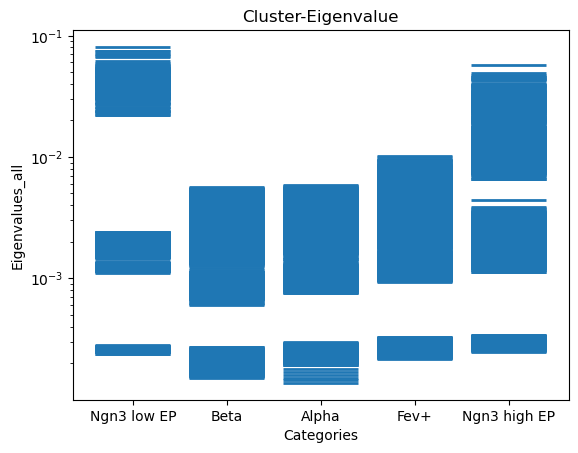

In [25]:
##被violin代替
categories = list(set(clusters))
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2)

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
plt.title('Cluster-Eigenvalue')

ax.set_xlabel('Categories')
ax.set_ylabel('Eigenvalues_all')

plt.show()

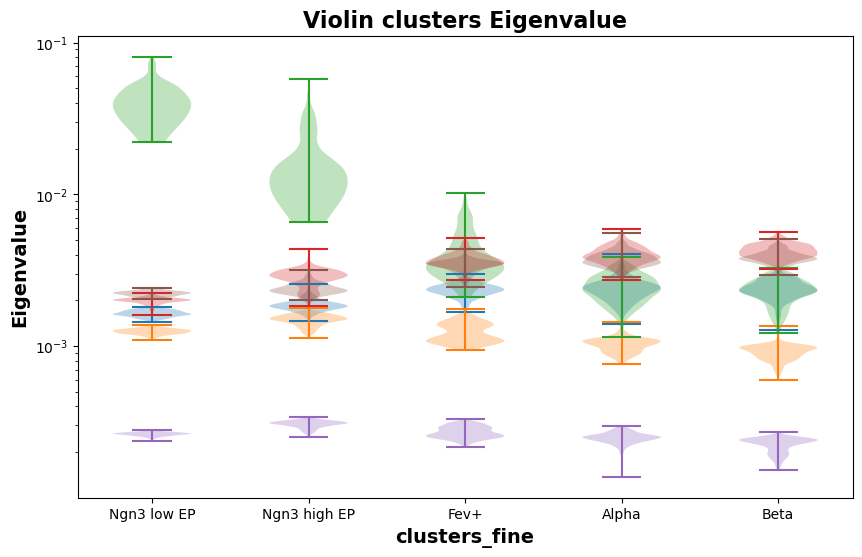

In [28]:
##不同颜色表示不同维度特征值
categories = list(set(clusters[np.argsort(color_label)]))
categories.sort(key = list(clusters[np.argsort(color_label)]).index)
categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(10, 6))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(L):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories)
if len(categories)>10:
    plt.xticks(rotation=40)
plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('clusters_fine',fontsize=14,weight='bold')
plt.ylabel('Eigenvalue',fontsize=14,weight='bold')

plt.show()

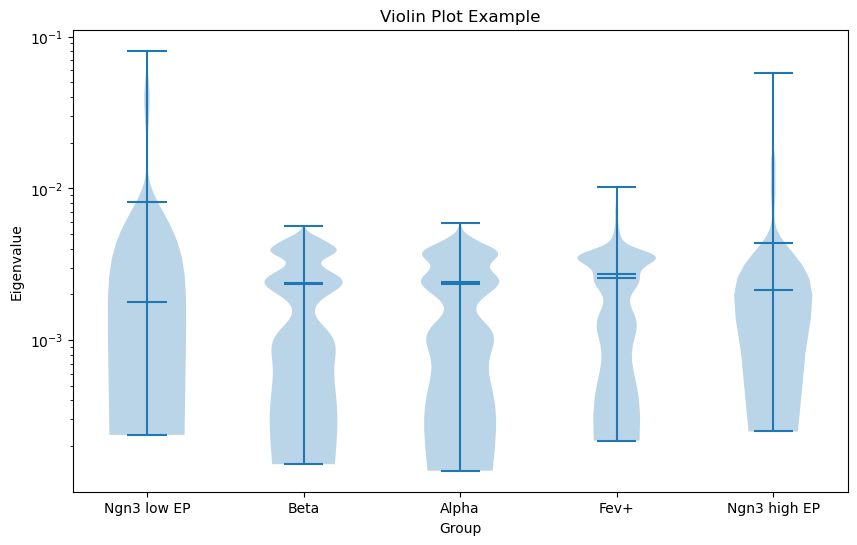

In [29]:
# 合并6个维度violinplot
categories = list(set(clusters))
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(10, 6))
plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
 
# 设置轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories)
plt.yscale('log')

# 添加标题和标签
plt.title('Violin Plot Example')
plt.xlabel('Group')
plt.ylabel('Eigenvalue')
 
plt.show()